# Import Libraries

In [1]:
import pandas as pd
import requests

import yfinance as yf
from pandas_datareader import data as pdr

In [2]:
import datetime as dt

In [53]:
pd.options.display.max_columns=1000

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Folder Paths

In [54]:
raw_data_folder = "Data/raw"
presentation_data_folder = "Data/presentation"

<hr>

# Ingest & Transform Data 

## PBT Historical Asset Price

### Ingest from Yahoo Finance API

#### Get Current Date

In [55]:
present_date = dt.datetime.strftime(dt.datetime.now(), '%Y-%m-%d')
present_date

'2022-01-05'

In [56]:
yf.pdr_override()

# download dataframe
data = pdr.get_data_yahoo("PBT", start="2000-01-01", end=present_date)


[*********************100%***********************]  1 of 1 completed


### Transform - Select Columns

In [57]:
#resetting index to make date a column and only taking closing price and date
historical_close = data.reset_index()[['Date', 'Close']]
historical_close.head()
historical_close.to_csv(f"{presentation_data_folder}/pbt_asset_price/pbt asset price.csv", index = False)

,Date,Close
0,2000-01-03,5.5000
1,2000-01-04,5.3750
2,2000-01-05,5.4375
3,2000-01-06,5.3750
4,2000-01-07,5.3750


<hr>


## Oil Price by Month - Excel Download
* Source URL: https://www.eia.gov/dnav/pet/hist/LeafHandler.ashx?n=PET&s=RWTC&f=M

### Ingest from Excel File Download

In [58]:
oilPricebyMonth = pd.read_csv(f"{raw_data_folder}/oil_prices/Cushing_OK_WTI_Spot_Price_FOB.csv", header = 4)

### Transform - Rename columns and Format Date Field

In [59]:
oilPricebyMonth.rename(columns = {oilPricebyMonth.columns[-1]: 'monthly_oil_price'}, inplace=True)

oilPricebyMonth.head()


,Month,monthly_oil_price
0,Nov 2021,79.15
1,Oct 2021,81.48
2,Sep 2021,71.65
3,Aug 2021,67.73
4,Jul 2021,72.49


In [60]:
testDate = oilPricebyMonth.iloc[0]['Month']
dt.datetime.strptime(testDate, '%b %Y')

oilPricebyMonth["Month"] = oilPricebyMonth['Month'].apply(lambda x: dt.datetime.strptime(x, '%b %Y'))

oilPricebyMonth["Adj Oil Price 1E-1"] = oilPricebyMonth['monthly_oil_price'] / 10
oilPricebyMonth.head()

datetime.datetime(2021, 11, 1, 0, 0)

,Month,monthly_oil_price,Adj Oil Price 1E-1
0,2021-11-01,79.15,7.915
1,2021-10-01,81.48,8.148
2,2021-09-01,71.65,7.165
3,2021-08-01,67.73,6.773
4,2021-07-01,72.49,7.249


In [61]:
oilPricebyMonth.to_csv(f"{presentation_data_folder}/oil_prices/oil price by month.csv", index = False)

## Gas Price by Month - Excel Download
* Source Url: https://www.eia.gov/dnav/ng/hist/rngwhhdm.htm

### Ingest from Excel File Download

In [62]:
gasPricebyMonth = pd.read_excel(f"{raw_data_folder}/gas_prices/RNGWHHDm.xls", sheet_name= 'Data 1', header = 2)

### Transform - Rename columns

In [63]:
gasPricebyMonth.rename(columns = {gasPricebyMonth.columns[-1]: 'monthly_gas_price'}, inplace=True)

gasPricebyMonth.head()
gasPricebyMonth.to_csv(f"{presentation_data_folder}/gas_prices/gas price by month.csv", index = False)

,Date,monthly_gas_price
0,1997-01-15,3.45
1,1997-02-15,2.15
2,1997-03-15,1.89
3,1997-04-15,2.03
4,1997-05-15,2.25


<hr>
<br>



## Historical Field Production

### Ingest historical production

In [64]:
historical_prod = pd.read_csv(f'{raw_data_folder}/historical_production/Historical Production.csv')

### Transform - Convert String Timestamp to Date and Adding Fields

In [65]:
historical_prod['Date'] = pd.to_datetime(historical_prod['Date'])

historical_prod['Mbbl/month'] = historical_prod['Oil']/1E3
historical_prod['Ten\'s of Thousand bbl /month (1E-4)'] = historical_prod['Oil']/1E4

historical_prod['MMcf/month'] = historical_prod['Gas']/1E3
historical_prod['Ten\'s of Thousand mcf /month (1E-4)'] = historical_prod['Gas']/1E4

In [66]:
historical_prod.to_csv(f'{presentation_data_folder}/historical_production/historical_production.csv', index = False)

<hr>
<br>

## Wells in Field

### Ingest Wells

In [67]:
wells = pd.read_csv(f'{raw_data_folder}/wells/Production Table.csv')

### Transform - Add Fields

In [68]:
wells["Total MMbbl"] = wells['Cum Oil']/1E6
wells["Total BCF"] = wells['Cum Gas']/1E6

In [69]:
wells.to_csv(f'{presentation_data_folder}/wells/wells.csv', index = False)

<hr>
<br>

## Permits

### Ingest Permits

In [70]:
permits = pd.read_csv(f'{raw_data_folder}/permits/Permits Table.csv')

### Transform - Group Similar Values in Well Status Field

In [71]:
def group_categories(value, similar_categories, target_category):
    '''
    similar_categories: list of values that wish to be grouped together
    target_category: value for similar values to be grouped to
    value: value in row of DataFrame
    '''
    if value in similar_categories:
        return target_category
    else:
        return value

In [72]:
vals_to_be_grouped = ['DUC', 'COMPLETED', 'INACTIVE', 'DRILLED']

In [73]:
permits['Well Status Grouped'] = permits['Well Status'].apply(lambda x: group_categories(x, vals_to_be_grouped, 'Drilled, Not Producing'))

In [74]:
permits['Well Status Grouped'].value_counts()

PERMITTED                 77
Drilled, Not Producing    68
ACTIVE                    34
UNKNOWN                   11
CANCELLED                  3
DRILLING                   2
P & A                      1
Name: Well Status Grouped, dtype: int64

In [75]:
permits.to_excel(f'{presentation_data_folder}/permits/permits.xlsx', index = False)

<hr>
<br>

# Combined Tables for Analysis

## Gross Revenue 

In [88]:
historical_prod.head(1)
oilPricebyMonth.head(1)
gasPricebyMonth.head(1)

,Date,Oil,Gas,Water,Well Count,Mbbl/month,Ten's of Thousand bbl /month (1E-4),MMcf/month,Ten's of Thousand mcf /month (1E-4),Date Key
0,1941-01-01,4684,0,16736,1,4.684,0.4684,0.0,0.0,1941-01


,Month,monthly_oil_price,Adj Oil Price 1E-1,Date Key
0,2021-11-01,79.15,7.915,2021-11


,Date,monthly_gas_price,Date Key
0,1997-01-15,3.45,1997-01


### Transform - Create Field for Joining Tables

In [85]:
#creating field for joining 3 tables since dates resembling each month differ slightly
historical_prod['Date Key'] = historical_prod['Date'].apply(lambda x: dt.datetime.strftime(x, '%Y-%m'))
gasPricebyMonth['Date Key'] = gasPricebyMonth['Date'].apply(lambda x: dt.datetime.strftime(x, '%Y-%m'))
oilPricebyMonth['Date Key'] = oilPricebyMonth['Month'].apply(lambda x: dt.datetime.strftime(x, '%Y-%m'))

In [89]:
historical_prod.head(2)
oilPricebyMonth.head(2)
gasPricebyMonth.head(2)

,Date,Oil,Gas,Water,Well Count,Mbbl/month,Ten's of Thousand bbl /month (1E-4),MMcf/month,Ten's of Thousand mcf /month (1E-4),Date Key
0,1941-01-01,4684,0,16736,1,4.684,0.4684,0.0,0.0,1941-01
1,1941-02-01,5458,0,19502,1,5.458,0.5458,0.0,0.0,1941-02


,Month,monthly_oil_price,Adj Oil Price 1E-1,Date Key
0,2021-11-01,79.15,7.915,2021-11
1,2021-10-01,81.48,8.148,2021-10


,Date,monthly_gas_price,Date Key
0,1997-01-15,3.45,1997-01
1,1997-02-15,2.15,1997-02


### Perform Join and Clean Up Fields

In [105]:
#merging 3 tables together to get commodity pricing along side production. Then cleaning up by selecting only necessary columns
revenue = pd.merge(historical_prod, oilPricebyMonth.drop(columns = 'Month'), on = 'Date Key', how = 'inner') \
    .merge(gasPricebyMonth.drop(columns = 'Date'), on = 'Date Key', how = 'inner') \
    .drop(columns = 'Date Key') \
    .loc[:,['Date', 'Oil', 'Gas', 'monthly_oil_price', 'monthly_gas_price']]

### Calculate Revenue for Oil, Gas, and Total

In [106]:
revenue["Revenue Oil"] = revenue["Oil"] * revenue['monthly_oil_price']
revenue["Revenue Gas"] = revenue["Gas"] * revenue['monthly_gas_price']

revenue['Total Revenue'] = revenue["Revenue Oil"] + revenue["Revenue Gas"]

revenue['$M Total Revenue'] = round(revenue["Total Revenue"] / 1E6, 2)

revenue

In [129]:
revenue.to_csv(f'{presentation_data_folder}/revenue/revenue.csv', index = False)

In [121]:
import seaborn as sns
import matplotlib.pyplot as plt

<Figure size 1080x504 with 0 Axes>

Text(0.5, 1.0, 'Revnue ($M) vs Year')

/Users/Mishaun_Bhakta/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:title={'center':'Revnue ($M) vs Year'}, xlabel='Date', ylabel='$M Total Revenue'>

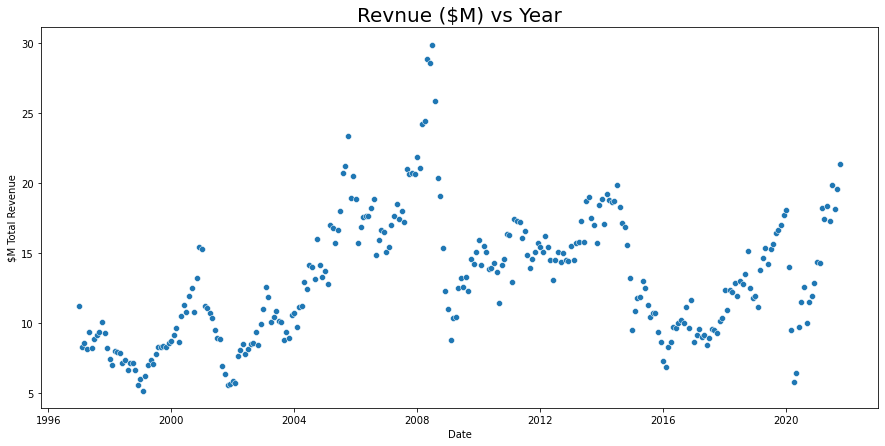

In [128]:
plt.figure(figsize=(15,7))
plt.title('Revnue ($M) vs Year', fontdict={"fontsize": 20})
sns.scatterplot(revenue['Date'], revenue['$M Total Revenue'])